In [ ]:
# 用标注好的数据集训练模型并预测新数据集

In [1]:
import pandas as pd
import json
from sklearn.preprocessing import MultiLabelBinarizer

# 读取jsonl文件
file_path = r'C:\Users\25809\Downloads\yuyun.jsonl'

data = []
with open(file_path, 'r', encoding='utf-8') as f:
    for line in f:
        data.append(json.loads(line))

# 转换为DataFrame
df = pd.DataFrame(data)

# 提取原有标签和添加新的标签
def extract_labels(df):
    # 定义standardization和customization的标签集合
    standardization_labels = {'Experience', 'Skill', 'Politeness', 'Confidence', 'Techsupport'}
    customization_labels = {'Fitness', 'Understand', 'Worktime'}
    
    # 提取原有标签
    df['labels'] = df['entities'].apply(lambda x: [ent['label'] for ent in x])
    
    # 为每个样本添加standardization和customization标签
    df['labels'] = df.apply(lambda row: row['labels'] + ['Standardization'] if any(label in standardization_labels for label in row['labels']) else row['labels'], axis=1)
    df['labels'] = df.apply(lambda row: row['labels'] + ['Customization'] if any(label in customization_labels for label in row['labels']) else row['labels'], axis=1)
    
    return df

# 处理数据框
df = extract_labels(df)

# 为每个标签创建独热编码
mlb = MultiLabelBinarizer()
label_binarized = pd.DataFrame(mlb.fit_transform(df['labels']), columns=mlb.classes_)

# 将独热编码结果与原数据框合并
df = pd.concat([df, label_binarized], axis=1)

# 输出最终的DataFrame
print(df.head())

print(mlb.classes_)


     id                                               text  \
0  8937                                           Sentence   
1  8938    I am an experienced web developer from Polan...   
2  8939    Please check my previous works:   http://www...   
3  8940      Please ping me to discuss it further in chat.   
4  8941                                   " Best regards,"   

                                            entities relations Comments  \
0                                                 []        []       []   
1  [{'id': 17, 'label': 'Experience', 'start_offs...        []       []   
2  [{'id': 18, 'label': 'Experience', 'start_offs...        []       []   
3  [{'id': 19, 'label': 'Politeness', 'start_offs...        []       []   
4  [{'id': 20, 'label': 'Politeness', 'start_offs...        []       []   

                                              labels  Confidence  \
0                                                 []           0   
1  [Experience, Experience, Experience, 

In [2]:
import re
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

# 文本预处理函数
def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)   # 移除非英文字符
    text = text.lower()   # 小写转换
    words = word_tokenize(text)   # 分词
    stop_words = set(stopwords.words('english'))   # 移除停用词
    words = [word for word in words if word not in stop_words]
    lemmatizer = WordNetLemmatizer()   # 词根提取
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

# 对文本数据进行预处理
df['processed_text'] = df['text'].apply(preprocess_text)


Processing ROC for Confidence...
Processing Logistic Regression...
Processing SVM...
Processing Random Forest...
Processing Naive Bayes...


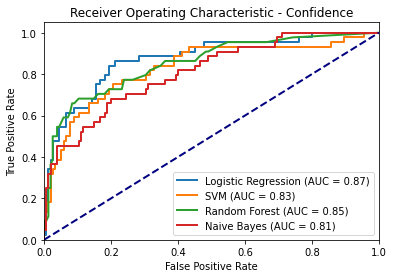


Processing ROC for Customization...
Processing Logistic Regression...
Processing SVM...
Processing Random Forest...
Processing Naive Bayes...


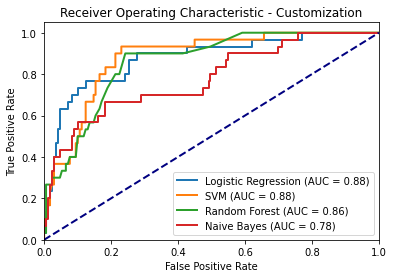


Processing ROC for Experience...
Processing Logistic Regression...
Processing SVM...
Processing Random Forest...
Processing Naive Bayes...


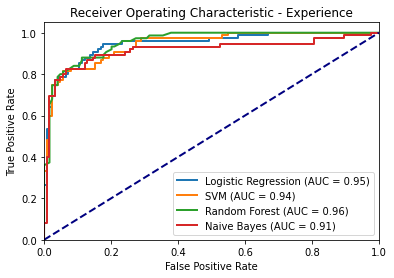


Processing ROC for Fitness...
Processing Logistic Regression...
Processing SVM...
Processing Random Forest...
Processing Naive Bayes...


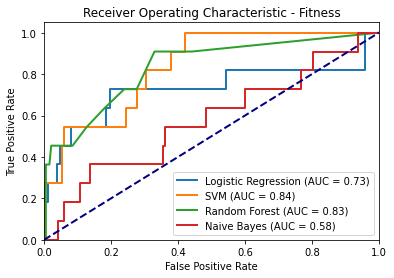


Processing ROC for Politeness...
Processing Logistic Regression...
Processing SVM...
Processing Random Forest...
Processing Naive Bayes...


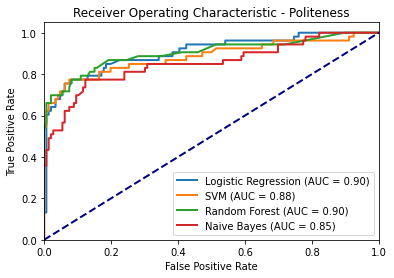


Processing ROC for Skill...
Processing Logistic Regression...
Processing SVM...
Processing Random Forest...
Processing Naive Bayes...


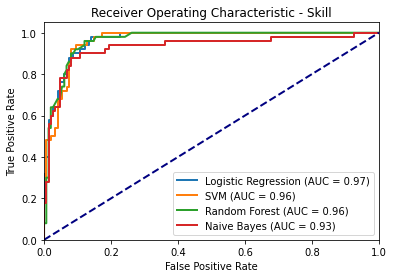


Processing ROC for Standardization...
Processing Logistic Regression...
Processing SVM...
Processing Random Forest...
Processing Naive Bayes...


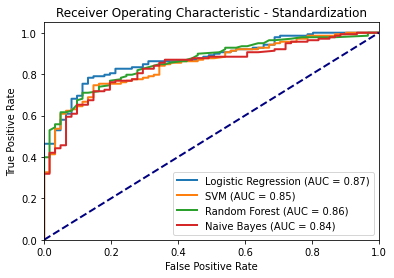


Processing ROC for TechSupport...
Processing Logistic Regression...
Processing SVM...
Processing Random Forest...
Processing Naive Bayes...


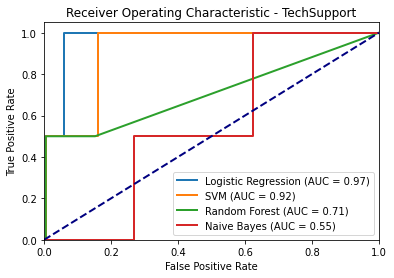


Processing ROC for Understand...
Processing Logistic Regression...
Processing SVM...
Processing Random Forest...
Processing Naive Bayes...


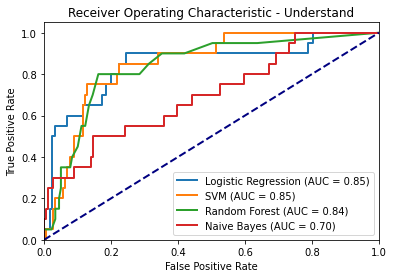


Processing ROC for WorkTime...
Processing Logistic Regression...
Processing SVM...
Processing Random Forest...
Processing Naive Bayes...


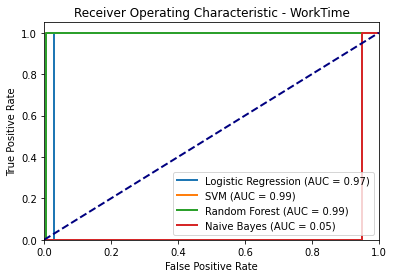

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
import joblib
from sklearn.multiclass import OneVsRestClassifier

# 定义你的分类器列表
classifiers = {
    'Logistic Regression': OneVsRestClassifier(LogisticRegression(max_iter=1000)),
    'SVM': OneVsRestClassifier(SVC(probability=True)),
    'Random Forest': OneVsRestClassifier(RandomForestClassifier()),
    'Naive Bayes': OneVsRestClassifier(MultinomialNB())
}

# 使用MultiLabelBinarizer进行标签二值化
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['labels'])

# 文本特征提取（Bag of Words和TF-IDF）
vectorizer_bow = CountVectorizer()
X_bow = vectorizer_bow.fit_transform(df['processed_text'])

vectorizer_tfidf = TfidfVectorizer()
X_tfidf = vectorizer_tfidf.fit_transform(df['processed_text'])

# 分割训练集和测试集
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X_bow, y, test_size=0.2, random_state=42)
X_train_tfidf, X_test_tfidf, _, _ = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# 对每个标签绘制ROC曲线并训练模型
for i, label in enumerate(mlb.classes_):
    plt.figure()
    print(f"\nProcessing ROC for {label}...")

    for name, clf in classifiers.items():
        print(f"Processing {name}...")

        # 训练分类器
        clf.fit(X_train_bow, y_train[:, i])

        # 预测概率
        if hasattr(clf, "predict_proba"):
            y_score = clf.predict_proba(X_test_bow)[:, 1]
        else:
            y_score = clf.decision_function(X_test_bow)

        # 计算ROC曲线
        fpr, tpr, _ = roc_curve(y_test[:, i], y_score)
        roc_auc = auc(fpr, tpr)

        # 绘制ROC曲线
        plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

        # 保存模型
        joblib.dump(clf, f'{name.lower().replace(" ", "_")}_{label}_model.pkl')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {label}')
    plt.legend(loc="lower right")
    plt.show()


In [6]:
# 加载模型
logistic_regression_confidence = joblib.load('logistic_regression_Confidence_model.pkl')
logistic_regression_customization = joblib.load('logistic_regression_Customization_model.pkl')
logistic_regression_politeness = joblib.load('logistic_regression_Politeness_model.pkl')
logistic_regression_skill = joblib.load('logistic_regression_Skill_model.pkl')
logistic_regression_standardization = joblib.load('logistic_regression_Standardization_model.pkl')
logistic_regression_techsupport = joblib.load('logistic_regression_TechSupport_model.pkl')
logistic_regression_understand = joblib.load('logistic_regression_Understand_model.pkl')
svm_fitness = joblib.load('svm_Fitness_model.pkl')
random_forest_experience = joblib.load('random_forest_Experience_model.pkl')
random_forest_worktime = joblib.load('random_forest_WorkTime_model.pkl')


In [7]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

# 加载新数据集
new_data_path = r"C:\Users\25809\Downloads\processed_bid_sentences.xlsx"
new_df = pd.read_excel(new_data_path)

new_df['processed_text'] = new_df.apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

print(new_df.head())

X_new_bow = vectorizer_bow.transform(new_df['processed_text'])

         bid                                          sentences Unnamed: 2  \
0  256634717  ['hello', 'ravindra', 'top', 'rated', 'preferr...        NaN   
1  256634717  ['satisfactory', 'work', 'within', 'given', 't...        NaN   
2  256634717  ['please', 'look', 'recent', 'work', 'flutter'...        NaN   
3  256634717  ['cross', 'platform', 'dart', 'thanks', 'ravin...        NaN   
4  256629301  ['hello', 'flutter', 'mobile', 'app', 'develop...        NaN   

  Unnamed: 3 Unnamed: 4 Unnamed: 5 Unnamed: 6 Unnamed: 7 Unnamed: 8  \
0        NaN        NaN        NaN        NaN        NaN        NaN   
1        NaN        NaN        NaN        NaN        NaN        NaN   
2        NaN        NaN        NaN        NaN        NaN        NaN   
3        NaN        NaN        NaN        NaN        NaN        NaN   
4        NaN        NaN        NaN        NaN        NaN        NaN   

  Unnamed: 9  ... Unnamed: 18 Unnamed: 19 Unnamed: 20 Unnamed: 21 Unnamed: 22  \
0        NaN  ...      

In [8]:
# 为每个标签做预测
predictions = {}

# Logistic Regression for confidence, customization, skill, standardization
predictions['confidence'] = logistic_regression_confidence.predict(X_new_bow)
predictions['customization'] = logistic_regression_customization.predict(X_new_bow)
predictions['skill'] = logistic_regression_skill.predict(X_new_bow)
predictions['standardization'] = logistic_regression_standardization.predict(X_new_bow)
predictions['politeness'] = logistic_regression_politeness.predict(X_new_bow)
predictions['understand'] = logistic_regression_understand.predict(X_new_bow)
predictions['techsupport'] = logistic_regression_techsupport.predict(X_new_bow)


# SVM for understand, fitness
predictions['fitness'] = svm_fitness.predict(X_new_bow)

# Random Forest for experience, politeness
predictions['experience'] = random_forest_experience.predict(X_new_bow)
predictions['worktime'] = random_forest_worktime.predict(X_new_bow)

# 将预测结果添加回数据框
for label, pred in predictions.items():
    new_df[label + '_prediction'] = pred

# 检查带有预测结果的数据
print(new_df.head())


         bid                                          sentences Unnamed: 2  \
0  256634717  ['hello', 'ravindra', 'top', 'rated', 'preferr...        NaN   
1  256634717  ['satisfactory', 'work', 'within', 'given', 't...        NaN   
2  256634717  ['please', 'look', 'recent', 'work', 'flutter'...        NaN   
3  256634717  ['cross', 'platform', 'dart', 'thanks', 'ravin...        NaN   
4  256629301  ['hello', 'flutter', 'mobile', 'app', 'develop...        NaN   

  Unnamed: 3 Unnamed: 4 Unnamed: 5 Unnamed: 6 Unnamed: 7 Unnamed: 8  \
0        NaN        NaN        NaN        NaN        NaN        NaN   
1        NaN        NaN        NaN        NaN        NaN        NaN   
2        NaN        NaN        NaN        NaN        NaN        NaN   
3        NaN        NaN        NaN        NaN        NaN        NaN   
4        NaN        NaN        NaN        NaN        NaN        NaN   

  Unnamed: 9  ... confidence_prediction customization_prediction  \
0        NaN  ...                   